***Méthodes numériques: Module 4***

# Réaction-Diffusion: modèle de Gray-Scott.

Dans ce travail nous allons étudier le phénomène de réaction et de diffusion de deux espèces chimiques dans un espace à deux dimensions. Nous le traiterons selon le modèle de Gray-Scott, expliqué ci-dessous et nous discuterons ensuite nos résultats. Pour visualiser l'évolution de la situation, nous allons dessiner des cartes où les concentrations des deux espèces chimique seront représentées par un gradient de couleurs.
Nous commencons par importer la librairie numpy, matplotlib et matplotlib.cm qui nous permettra de dessiner les cartes.
Ensuite nous importons le fichier contenant les données initiales u et v qui se trouve dans le fichier data du même dépôt.

In [1]:
import numpy
from matplotlib import pyplot
import matplotlib.cm as cm
%matplotlib inline

In [2]:
uvinitial = numpy.load('./data/uvinitial.npz')
U = uvinitial['U']
V = uvinitial['V']

In [ ]:
fig = pyplot.figure(figsize=(8,5))
pyplot.subplot(121)
pyplot.imshow(U, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);
pyplot.subplot(122)
pyplot.imshow(V, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);

## Principe ##

On étudie l'évolution de deux espèces chimiques U et V dont la concentration est donnée par les variables u et v et qui:
 - se diffusent chacune à leur propre taux (resp. Du et Dv)
 - peuvent interagir par $2U+V\rightarrow 3V$
 - l'espèce U est réintroduite constamment à un taux constant et l'espèce V est éliminée à un autre taux constant
Toutes ces conditions se traduisent, selon le modèle de Gray-Scott par les équations différentielles différentes.

Le système d'équations différentielles à résoudre s'écrit:


\begin{align}
\frac{\partial u}{\partial t} &= D_u \nabla ^2 u - uv^2 + F(1-u)\\
\frac{\partial v}{\partial t} &= D_v \nabla ^2 v + uv^2 - (F + k)v
\end{align}

## Méthode explicite

Nous allons le discrétiser vers l'avant dans le temps et par un schéma centré dans l'espace (forward-time,centred-space). Nous allons le résoudre par un schéma explicite: la discrétisation dans l'espace s'effectue au temps n:


\begin{align}
\frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}= D_{u}*(\frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{\Delta x^2}+\frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{\Delta y^2})-u_{i,j}^{n}*(v_{i,j}^{n})^2+F(1-u_{i,j}^{n})\\
\frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t}=D_{v}*(\frac{v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}}{\Delta x^2}+\frac{v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}}{\Delta y^2})+u_{i,j}^{n}*(v_{i,j}^{n})^2-(F+k)v_{i,j}^{n}
\end{align}

On pose ensuite 
\begin{equation}
\Delta x^2=\Delta y^2=\delta^2\\
\end{equation}
Afin de pouvoir utiliser effectivement la méthode explicite, nous devons nous assurer que la condition de stabilité est respectée, dans notre cas:
\begin{align}
D_{u}\frac{\Delta t}{\Delta x^2}<\frac{1}{4}\\
D_{v}\frac{\Delta t}{\Delta y^2}<\frac{1}{4}
\end{align}
que l'on peut dans ce cas-ci réécrire:
\begin{align}
\Delta t< \frac{1}{4}\frac{\delta^2}{\max(D_u, D_v)}\\
\end{align}
Nous choissisons donc: 
\begin{align}
\Delta t= \frac{9}{40}\frac{\delta^2}{\max(D_u, D_v)}
\end{align}

On met tous les termes connus dans le membre de droite et les termes inconnus dans le membre de gauche:

\begin{align}
u_{i,j}^{n+1}=u_{i,j}^{n}+\Delta t\left(Du*(\frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{\delta^2}+\frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{\delta^2})-u_{i,j}^{n}*(v_{i,j}^{n})^2+F(1-u_{i,j}^{n})\right)\\
v_{i,j}^{n+1}=v_{i,j}^{n}+\Delta t\left(Dv*(\frac{v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}}{\delta^2}+\frac{v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}}{\delta^2})+u_{i,j}^{n}*(v_{i,j}^{n})^2-(F+k)v_{i,j}^{n}\right)
\end{align}  

que nous réécrivons comme:  

\begin{align}
u_{i,j}^{n+1}=u_{i,j}^{n}*\left(1-4\frac{\Delta t*Du}{\delta^2}-\Delta t*(v_{i,j}^n)^2-\Delta t*F\right)+\Delta t\left(Du*(\frac{u_{i+1,j}^{n}+u_{i-1,j}^{n}+u_{i,j+1}^{n}+u_{i,j-1}^{n}}{\delta^2})+F\right)\\
v_{i,j}^{n+1}=v_{i,j}^{n}*\left(1-4\frac{\Delta t*Dv}{\delta^2}-\Delta t*(F+k)\right)+\Delta t\left(Dv*(\frac{v_{i+1,j}^{n}+v_{i-1,j}^{n}+v_{i,j+1}^{n}+v_{i,j-1}^{n}}{\delta^2})+u_{i,j}^{n}*(v_{i,j}^{n})^2\right)\\
\end{align}
C'est ce dernier système de deux équations que nous allons résoudre.

### Conditions aux bords

Les conditions aux bords sont des conditions de Neumann, c'est-à-dire que:
\begin{align}
u_{i,1}^{n+1} = u_{i,0}^{n+1},\,u_{i,N-2}^{n+1} = u_{i,N-1}^{n+1}\\
v_{i,1}^{n+1} = v_{i,0}^{n+1},\,v_{i,N-2}^{n+1} = v_{i,N-1}^{n+1}\\
u_{1,j}^{n+1} = u_{0,j}^{n+1},\,u_{N-2,j}^{n+1} = u_{N-1,j}^{n+1}\\
v_{1,j}^{n+1} = v_{0,j}^{n+1},\,v_{N-2,j}^{n+1} = v_{N-1,j}^{n+1}\\
\forall i,j \in \{\,0,\ldots,N-1\,\}\\
\end{align}
*Remarque*: N est la taille des matrices u et v c'est-à-dire que le nombre de pas spatiaux en directions x et y est N-1, n est le nombre de pas de temps. cela ne pose pas de problème car Python distingue les lettres minuscules et majuscules.

### Paramètres###
Nous introduisons ici les paramètres du problème.
La première cellule contient ceux qui resteront inchangés tout au long de notre travail. 
 - Le nombre N est la taille des matrice u et v initial, N-1 est donc le nombre de pas spatiaux. 
 - dh est la longueur de ce pas spatial nécessaire pour que la distance totale soit de 5 mètres. 
 - Nous allons effectuer notre discrétisation sur un temps total T de 8000s.

In [12]:
N = len(U)
print(N)
dh = 5/(N-1) #delta
T=8000

192


Nous introduisons à présent les paramètres qui changeront dans la suite du travail. La liste des conditions initiales contient: [Du,Dv,F,k]. Nous écrivons ici la première liste de paramètres CI1 que ous allons utiliser pour valider notre résolution. Nous introduirons plus tard d'autres listes.
Comme le temps dt( et donc également nt) dépend de Du et Dv, nous définissons dt et nt comme une fonction de notre liste de paramètres CI 

In [13]:
CI1=numpy.array([0.00016, 0.00008, 0.035, 0.065]) # Bacteria 1 

In [14]:
def dtandnt(CI):
    dt = .9 * dh**2 / (4*max(CI[0],CI[1]))
    nt=int(T/dt)
    return (dt,nt)

### Résolution explicite:

In [38]:
def grayscott(u0,v0,CI,N):
    Du=CI[0]
    Dv=CI[1]
    F=CI[2]
    k=CI[3]
    [dt,nt]=dtandnt(CI)
    ucopy=u0.copy()#nous copions les valeurs de u0 et v0 pour ne pas changer nos listes initiales
    vcopy=v0.copy()
    for n in range (nt):
        un=ucopy.copy()#cette copie garde les valeurs du temps précédent pour pouvoir les utiliser dans la discrétisation
        vn=vcopy.copy()
        ucopy[1:-1,1:-1]=un[1:-1,1:-1]*(1-4*dt*Du/dh**2-dt*(vn[1:-1,1:-1])**2-dt*F)\
                        +dt*Du*(un[2:,1:-1]+un[:-2,1:-1]+un[1:-1,2:]+un[1:-1,:-2])/(dh**2)+dt*F
        
        vcopy[1:-1,1:-1]=vn[1:-1,1:-1]*(1-4*dt*Dv/dh**2-dt*(F+k))+dt*Dv*(vn[2:,1:-1]+vn[:-2,1:-1]+vn[1:-1,2:]+vn[1:-1,:-2])/(dh**2)\
                        +dt*un[1:-1,1:-1]*(vn[1:-1,1:-1])**2
        #conditions de Neumann:
        ucopy[:,0]=ucopy[:,1]
        ucopy[0,:]=ucopy[1,:]
        ucopy[:,N-1]=ucopy[:,N-2]
        ucopy[N-1,:]=ucopy[N-2,:]
        vcopy[:,0]=vcopy[:,1]
        vcopy[0,:]=vcopy[1,:]
        vcopy[:,N-1]=vcopy[:,N-2]
        vcopy[N-1,:]=vcopy[N-2,:]
        
    return (ucopy,vcopy)

### Cartes

In [ ]:
def solandmap(CI):
    sol=grayscott(U,V,CI,192)
    fig = pyplot.figure(figsize=(14,5))
    pyplot.subplot(121)
    pyplot.imshow(sol[0], cmap = cm.RdBu)
    pyplot.title('Concentration en u')
    pyplot.xticks([]), pyplot.yticks([]);
    pyplot.colorbar()
    pyplot.subplot(122)
    pyplot.imshow(sol[1], cmap = cm.RdBu)
    pyplot.title('Concentration en v')
    pyplot.xticks([]), pyplot.yticks([]);
    pyplot.colorbar()

In [ ]:
solandmap(CI1)

### Solution des questions posées:
Pour vérifier que notre code donne la bonne solution, nous fournissons les valeurs de u de la 100ème ligne toutes les 40 valeurs.
Nous utilisons la fonction numpy.round pour obtenir les valeurs à la quatrième décimale.

In [ ]:
sol=grayscott(U,V,CI1,192)
print(numpy.round(sol[0][100,::40],4))

Ce sont les bonnes solutions, notre code fonctionne donc correctement.

### Evolution dans le temps
Nous allons à présent animer notre solution pour rendre le processus plus visuel.
Comme il s'agit d'une carte, nous ne pouvons pas utiliser les mêmes codes que dans les modules différents. Nous nous sommes inspirés de la documentation matplotlib et de l'exemple de ce lien: http://matplotlib.org/examples/animation/dynamic_image2.html.

In [ ]:
from matplotlib import animation
from IPython.display import HTML

Nous rappelons les paramètres utilisés:

In [ ]:
#Paramètres fixes
N=192
dh = 5/(N-1)
T=8000

#Paramètres variables (Du,Dv,F,k)
CI1=numpy.array([0.00016, 0.00008, 0.035, 0.065]) # Bacteria 1

Pour créer la vidéo, nous avons besoin de vecteurs reprenant nos solutions pour u et v à chaque étapes de temps j. Nous devons donc modifier un petit peu notre code pour cela.

In [ ]:
def vectors(CI):
    [dt,nt]=dtandnt(CI)
    uu=numpy.zeros((nt+1,N,N))
    uu[0]=U
    vv=numpy.zeros((nt+1,N,N))
    vv[0]=V
    Du=CI[0]
    Dv=CI[1]
    F=CI[2]
    k=CI[3]
    
    for n in range (nt):
        uu[n+1,1:-1,1:-1]=uu[n,1:-1,1:-1]*(1-4*dt*Du/dh**2-dt*(vv[n,1:-1,1:-1])**2-dt*F)\
                        +dt*Du*(uu[n,2:,1:-1]+uu[n,:-2,1:-1]+uu[n,1:-1,2:]+uu[n,1:-1,:-2])/(dh**2)+dt*F
            
        vv[n+1,1:-1,1:-1]=vv[n,1:-1,1:-1]*(1-4*dt*Dv/dh**2-dt*(F+k))+dt*Dv*(vv[n,2:,1:-1]+vv[n,:-2,1:-1]+vv[n,1:-1,2:]\
                        +vv[n,1:-1,:-2])/(dh**2)+dt*uu[n,1:-1,1:-1]*(vv[n,1:-1,1:-1])**2
        #conditions de Neumann:
        uu[n+1,:,0]=uu[n+1,:,1]
        uu[n+1,0,:]=uu[n+1,1,:]
        uu[n+1,:,N-1]=uu[n+1,:,N-2]
        uu[n+1,N-1,:]=uu[n+1,N-2,:]
        vv[n+1,:,0]=vv[n+1,:,1]
        vv[n+1,0,:]=vv[n+1,1,:]
        vv[n+1,:,N-1]=vv[n+1,:,N-2]
        vv[n+1,N-1,:]=vv[n+1,N-2,:]
    return(uu,vv)

Nous utilisons maintenant le même code que dans le lien, adapté à notre situation:

In [ ]:
uu=vectors(CI1)[0]
nt=len(uu)

In [ ]:
fig = pyplot.figure(figsize=(8,5))
ims = []
for i in range(0,nt+1,100):#we do it each 100 step to lower the calculation time
    im = pyplot.imshow(uu[i], cmap=cm.RdBu, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
pyplot.close()

Et nous pouvons à présent lancer l'animation!

In [ ]:
HTML(ani.to_html5_video())

Ceci correspond exactement à la solution montrée dans le module: ceci vérifie une fois de plus que notre code est correct.
Nous pouvons à présent utiliser ce code pour explorer d'autres paramètres!

### Autres paramètres:
Nous allons maintenant regarder d'autres patterns crées par différents paramètres initiaux.
Rappelons que les listes ci-dessous donnent les paramètres dans l'ordre suivant: [Du,Dv,F,k]

In [ ]:
I2=numpy.array([0.00014, 0.00006, 0.035, 0.065]) # Bacteria 2
I3=numpy.array([0.00016, 0.00008, 0.060, 0.062]) # Coral
I4=numpy.array([0.00019, 0.00005, 0.060, 0.062]) # Fingerprint
I5=numpy.array([0.00010, 0.00010, 0.018, 0.050]) # Spirals
I6=numpy.array([0.00012, 0.00008, 0.020, 0.050]) # Spirals Dense
I7=numpy.array([0.00010, 0.00016, 0.020, 0.050]) # Spirals Fast
I8=numpy.array([0.00016, 0.00008, 0.020, 0.055]) # Unstable
I9=numpy.array([0.00016, 0.00008, 0.050, 0.065]) # Worms 1
I10=numpy.array([0.00016, 0.00008, 0.054, 0.063]) # Worms 2
I11=numpy.array([0.00016, 0.00008, 0.035, 0.060]) # Zebrafish

Comme le calcul du vecteur (utilisé pour les animations) prend vraiment beaucoup de temps pour s'éxécuter, nous allons d'abord regarder le résultat final de chacune de ces modélisations en utilisant notre premier code (qui s'éxécute beaucoup plus rapidement) et puis nous feront certaines animations pour pouvoir discuter de l'évolution.

In [ ]:
solandmap(I2)

In [ ]:
solandmap(I3)

In [ ]:
solandmap(I4)

In [ ]:
solandmap(I5)

In [ ]:
solandmap(I6)

In [ ]:
solandmap(I7)

In [ ]:
solandmap(I8)

In [ ]:
solandmap(I9)

In [ ]:
solandmap(I10)

In [ ]:
solandmap(I11)

On voit que bien que les motifs soient différents, tous ont un comportement similaires à la première réaction, sauf les 3 spirales (I5, I6, I7). Nous allons étudier de plus près ces trois cas pour comprendre ce qu'il se passe.

In [ ]:
uu= vectors(I5)[0]
uu1=vectors(I6)[0]
uu2=vectors(I7)[0]
nt=len(uu)

In [ ]:
fig = pyplot.figure(figsize=(8,5))
ims = []
for i in range(0,5000,50):#on prend toutes les 50 étapes pour mieux comprendre ce qui se passe, on ne regarde que jusqu'à 5000 car ensuite la solution ne change de toute façon plus
    im = pyplot.imshow(uu[i], cmap=cm.RdBu, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=1000)
pyplot.close() 
    
HTML(ani.to_html5_video())

In [ ]:
fig = pyplot.figure(figsize=(8,5))
ims = []
for i in range(0,5000,50):
    im = pyplot.imshow(uu1[i], cmap=cm.RdBu, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=1000)
pyplot.close() 
    
HTML(ani.to_html5_video())

In [ ]:
fig = pyplot.figure(figsize=(8,5))
ims = []
for i in range(0,5000,50):
    im = pyplot.ims5ow(uu2[i], cmap=cm.RdBu, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=1000)
pyplot.close() 
    
HTML(ani.to_html5_video())

Nous constatons que pour ces trois listes de paramètres initiaux, les patterns ne sont pas ceux attendus (spirales), et qu'après un certain temps il semble ne plus rien se passer. 

**Comment comprendre ce phénomène?**

Etant donné que notre code nous donne exactement la bonne solution pour la première liste de paramètres, le problème ne peut pas se trouver là. Nous avons bien pris en compte les problèmes de stabilité dûe à l'utilisation de la méthode explicite dans la définition de notre dt donc le problème ne réside pas là non plus.

Que reste-t-il? 
 - Soit il s'agit d'un problème dû au fait que la propagation n'est pas instantanée mais demande une étape d'itération (le second défaut de la méthode explicite), mais cela semble peu probable puisque ce problème ne se pose pas avec toutes les autres listes de paramètres.
- Soit le problème provient directement des paramètres en tant que tels.

En effet, en nous renseignant sur Internet, nous avons remarqué que la plupart des simulations se faisait à un rapport $\frac{D_{u}}{D_{v}}$ fixé. Sur le site suivant: http://www.cs.mun.ca/~banzhaf/pycellchem/grayscott_intro.html, les conditions de stabilité pour qu'il y ait effectivement un pattern sont données comme:
\begin{equation}
\sigma=\frac{D_{u}}{D_{v}} \in [2,6]\\
\end{equation}
En effet, ces trois listes de paramètres sont les seules de tous nos patterns où cette condition n'est pas respectée.

**Remarque:** ce site donne également des conditions sur F et k mais d'après la classification de Pearson (http://mrob.com/pub/comp/xmorphia/pearson-classes.html), changer les paramètres F et k pour un $\sigma$ fixé (ici à 2), change le résultat et il y a formation de patterns seulement sur une fine bande comme on le voit sur cette image qui provient de même site:

<img src=".\xmorphia-parameter-map.jpg" width="400" height="400" />

#### Axe vertical: $F \in [0.0020, 0.1100]$ par pas de 0.0040
#### Axe horizontal: $k \in [0.0190,0.0730]$ par pas de 0.0020

En cherchant un peu plus, nous avons retrouvé d'où provenaient les listes de paramètres données dans le module: http://www.labri.fr/perso/nrougier/teaching/numpy/scripts/gray-scott.py. 
Ce site renvoie vers une application java (http://www.aliensaint.com/uo/java/rd/) où l'on peut entrer les paramètres F,k,Du et Dv et qui réalise l'animation du modèle Gray-scott de la même manière que notre code. Nous voyons qu'en rentrant les paramètres pour 'Spiral', 'Spiral Dense' et 'Spiral Fast', l'animation Java donne également des solutions où il ne se passe 'rien'. *Remarque: cette animation ne débute pas avec les même u et v initiaux.*

Nous cherchons une combinaison de paramètres qui pourrait donner des spirales et qui est correspond au conditions de stabilité décrites ci-dessus.

Source:http://mrob.com/pub/comp/xmorphia/F100/F100-k470.html

In [ ]:
Inew=[0.00020,0.0001,0.01,0.047]

In [ ]:
unew=vectors(Inew)[0]
nt=len(unew)

In [ ]:
fig = pyplot.figure(figsize=(8,5))
ims = []
for i in range(0,8000,50):
    im = pyplot.imshow(unew[i], cmap=cm.RdBu, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=1000)
pyplot.close() 
    
HTML(ani.to_html5_video())

## Méthode Semi-implicite

Cette fois-ci nous utilisons la méthode implicite mais non devons conserver une méthode explicite pourles parties non liénaires.

La discrétisation dans l'espace de dimension NxN (carré avec N points par côté) s'effectue comme suit en n+1 : 

\begin{align}
\frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}= D_{u}*(\frac{u_{i+1,j}^{n+1}-2u_{i,j}^{n+1}+u_{i-1,j}^{n+1}}{\Delta x^2}+\frac{u_{i,j+1}^{n+1}-2u_{i,j}^{n+1}+u_{i,j-1}^{n+1}}{\Delta y^2})-u_{i,j}^{n}*(v_{i,j}^{n})^2+F(1-u_{i,j}^{n+1})\\
\frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t}=D_{v}*(\frac{v_{i+1,j}^{n+1}-2v_{i,j}^{n+1}+v_{i-1,j}^{n+1}}{\Delta x^2}+\frac{v_{i,j+1}^{n+1}-2v_{i,j}^{n+1}+v_{i,j-1}^{n+1}}{\Delta y^2})+u_{i,j}^{n}*(v_{i,j}^{n})^2-(F+k)v_{i,j}^{n+1}
\end{align}

On a alors :

\begin{align}
{u_{i,j}^{n}}{(\frac{1}{\Delta t} - (v_{i,j}^{n})^2)} + F= \frac{-D_{u}}{\delta^2}({u_{i+1,j}^{n+1}+u_{i-1,j}^{n+1}+u_{i,j+1}^{n+1}+u_{i,j-1}^{n+1}})+u_{i,j}^{n+1}{(\frac{1}{\Delta t} + \frac{4D_{u}}{\delta^2}+F)}\\
{v_{i,j}^{n}}{(\frac{1}{\Delta t} + u_{i,j}^{n} v_{i,j}^{n})}= \frac{-D_{v}}{\delta^2}({v_{i+1,j}^{n+1}+v_{i-1,j}^{n+1}+v_{i,j+1}^{n+1}+v_{i,j-1}^{n+1}})+v_{i,j}^{n+1}{(\frac{1}{\Delta t} + \frac{4D_{v}}{\delta^2}+(F+k))}
\end{align}

Par la suite, par utilité pratique, on utilisera les notations :

\begin{align}
 C_{i,j}^{n}={u_{i,j}^{n}}{(\frac{1}{\Delta t} - (v_{i,j}^{n})^2)} + F\\
{E_{i,j}^{n}}={v_{i,j}^{n}}{(\frac{1}{\Delta t} + u_{i,j}^{n} v_{i,j}^{n})}
\end{align}

On peut donc écrire :

\begin{align}
C_{i,j}^{n} = \frac{-D_{u}}{\delta^2}({u_{i+1,j}^{n+1}+u_{i-1,j}^{n+1}+u_{i,j+1}^{n+1}+u_{i,j-1}^{n+1}})+u_{i,j}^{n+1}{(\frac{1}{\Delta t} + \frac{4D_{u}}{\delta^2}+F)}\\
E_{i,j}^{n}= \frac{-D_{v}}{\delta^2}({v_{i+1,j}^{n+1}+v_{i-1,j}^{n+1}+v_{i,j+1}^{n+1}+v_{i,j-1}^{n+1}})+v_{i,j}^{n+1}{(\frac{1}{\Delta t} + \frac{4D_{v}}{\delta^2}+(F+k))}
\end{align}

### Conditions aux bords

Posons les conditions de Neumann aux bords.

#### Bord inférieur (j=0) : 

Les conditions sur la dérivée donnent :

\begin{align}
\frac{u_{i,1}^{n+1}-u_{i,0}^{n+1}}{\delta}=0\\
\frac{v_{i,1}^{n+1}-v_{i,0}^{n+1}}{\delta}=0\\
\\
u_{i,1}^{n+1} = u_{i,0}^{n+1}\\
v_{i,1}^{n+1} = v_{i,0}^{n+1}
\end{align}

Alors, en j=1, on trouve :

\begin{align}
u_{i,j}^{n+1}=u_{i,j-1}^{n+1}\\
v_{i,j}^{n+1}=v_{i,j-1}^{n+1}
\end{align}

Les équations pour j=1 sont donc:

\begin{align}
C_{i,1}^{n} = \frac{-D_{u}}{\delta^2}({u_{i+1,0}^{n+1}+u_{i-1,0}^{n+1}+u_{i,2}^{n+1}})+u_{i,0}^{n+1}{(\frac{1}{\Delta t} + \frac{3D_{u}}{\delta^2}+F)}\\
E_{i,1}^{n}= \frac{-D_{v}}{\delta^2}({v_{i+1,0}^{n+1}+v_{i-1,0}^{n+1}+v_{i,2}^{n+1}})+v_{i,0}^{n+1}{(\frac{1}{\Delta t} + \frac{3D_{v}}{\delta^2}+(F+k))}
\end{align}

#### Bord gauche (i=0) :

De manière similaire, on a :

\begin{align}
u_{1,j}^{n+1} = u_{0,j}^{n+1}\\
v_{1,j}^{n+1} = v_{0,j}^{n+1}
\end{align}

Et, en utilisant i=1 :

\begin{align}
C_{1,j}^{n} = \frac{-D_{u}}{\delta^2}({u_{0,j+1}^{n+1}+u_{0,j-1}^{n+1}+u_{2,j}^{n+1}})+u_{0,j}^{n+1}{(\frac{1}{\Delta t} + \frac{3D_{u}}{\delta^2}+F)}\\
E_{1,j}^{n}= \frac{-D_{v}}{\delta^2}({v_{0,j+1}^{n+1}+v_{0,j-1}^{n+1}+v_{2,j}^{n+1}})+v_{0,j}^{n+1}{(\frac{1}{\Delta t} + \frac{3D_{v}}{\delta^2}+(F+k))}
\end{align}

#### Bord supérieur (j=N-1) :

On a ici :

\begin{align}
\frac{u_{i,N-1}^{n+1}-u_{i,N-2}^{n+1}}{\delta}=0\\
\frac{v_{i,N-1}^{n+1}-v_{i,N-2}^{n+1}}{\delta}=0\\
\\
u_{i,N-2}^{n+1} = u_{i,N-1}^{n+1}\\
v_{i,N-2}^{n+1} = v_{i,N-1}^{n+1}
\end{align}

Et, en utilisant j=N-2 :

\begin{align}
C_{i,N-2}^{n} = \frac{-D_{u}}{\delta^2}({u_{i+1,N-1}^{n+1}+u_{i-1,N-1}^{n+1}+u_{i,N-3}^{n+1}})+u_{i,N-1}^{n+1}{(\frac{1}{\Delta t} + \frac{3D_{u}}{\delta^2}+F)}\\
E_{i,N-2}^{n} = \frac{-D_{v}}{\delta^2}({v_{i+1,N-1}^{n+1}+v_{i-1,N-1}^{n+1}+v_{i,N-3}^{n+1}})+v_{i,N-1}^{n+1}{(\frac{1}{\Delta t} + \frac{3D_{v}}{\delta^2}+(F+k))}
\end{align}

#### Bord droit (i=N-1) :

\begin{align}
u_{N-2,j}^{n+1} = u_{N-1,j}^{n+1}\\
v_{N-2,j}^{n+1} = v_{N-1,j}^{n+1}
\end{align}

Et, en utilisant i=N-2 :

\begin{align}
C_{N-2,j}^{n} = \frac{-D_{u}}{\delta^2}({u_{N-1,j+1}^{n+1}+u_{N-1,j-1}^{n+1}+u_{N-3,j}^{n+1}})+u_{N-1,j}^{n+1}{(\frac{1}{\Delta t} + \frac{3D_{u}}{\delta^2}+F)}\\
E_{N-2,j}^{n}= \frac{-D_{v}}{\delta^2}({v_{N-1,j+1}^{n+1}+v_{N-1,j-1}^{n+1}+v_{N-3,j}^{n+1}})+v_{N-1,j}^{n+1}{(\frac{1}{\Delta t} + \frac{3D_{v}}{\delta^2}+(F+k))}
\end{align}


In [3]:
from scipy.linalg import solve

In [15]:
N=48
dh=5/(N-1)

In [26]:
u0=U[::4,::4]
v0=V[::4,::4]

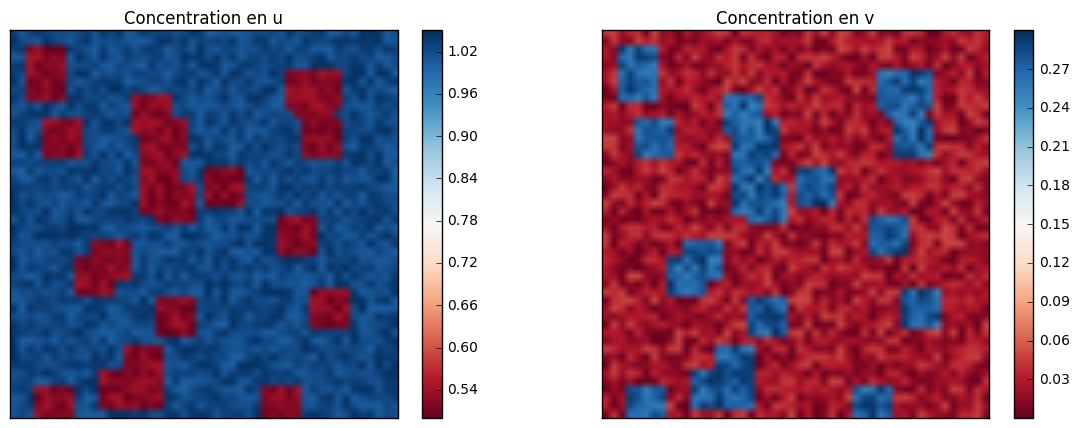

In [27]:
    fig = pyplot.figure(figsize=(14,5))
    pyplot.subplot(121)
    pyplot.imshow(u0, cmap = cm.RdBu)
    pyplot.title('Concentration en u')
    pyplot.xticks([]), pyplot.yticks([]);
    pyplot.colorbar()
    pyplot.subplot(122)
    pyplot.imshow(v0, cmap = cm.RdBu)
    pyplot.title('Concentration en v')
    pyplot.xticks([]), pyplot.yticks([]);
    pyplot.colorbar()

In [28]:
def constructMatrix(Du, dh, dt,add):
    #add prendra la valeur -F pour construire la matrice pour u et +(F+k) pour v
    A = numpy.zeros(((N-2)*(N-2),(N-2)*(N-2)))
    
    row_number = 0 # row counter
    
    for j in range(1,N-1):
        for i in range(1,N-1):
            #Corners
            if i==1 and j==1: # Left-Bottom
                A[row_number,row_number] = (1./dt)+2*Du/(dh**2)+add # Set diagonal
                A[row_number,row_number+1] = -Du/(dh**2)       # fetch i+1
                A[row_number,row_number+N-2] = -Du/(dh**2)    # fetch j+1
            
            elif i==N-2 and j==N-2: # Right-Top
                A[row_number,row_number] = (1./dt)+2*Du/(dh**2)+add # Set diagonal
                A[row_number,row_number-1] = -Du/(dh**2)      # Fetch i-1
                A[row_number,row_number-(N-2)] = -Du/(dh**2)  # fetch j-1
                
            elif j==1 and i==N-2: # Bottom-Right
                A[row_number,row_number] = (1./dt)+2*Du/(dh**2)+add # Set diagonal
                A[row_number,row_number-1] = -Du/(dh**2)       # fetch i-1
                A[row_number,row_number+N-2] = -Du/(dh**2)    # fetch j+1
                
            elif j==N-2 and i==1: # Top-Left
                A[row_number,row_number] = (1./dt)+2*Du/(dh**2)+add # Set diagonal
                A[row_number,row_number+1] = -Du/(dh**2)      # fetch i+1
                A[row_number,row_number-(N-2)] = -Du/(dh**2)  # fetch j-1            
            # Sides
            elif i==1: # Left boundary
                A[row_number,row_number] = (1/dt)+3*Du/(dh**2)+add # Set diagonal
                A[row_number,row_number+1] = -Du/(dh**2)       # fetch i+1
                A[row_number,row_number+N-2] = -Du/(dh**2)    # fetch j+1
                A[row_number,row_number-(N-2)] = -Du/(dh**2)  # fetch j-1
            
            elif i==N-2: # Right boundary
                A[row_number,row_number] = (1/dt)+3*Du/(dh**2)+add # Set diagonal
                A[row_number,row_number-1] = -Du/(dh**2)      # Fetch i-1
                A[row_number,row_number+N-2] = -Du/(dh**2)    # fetch j+1
                A[row_number,row_number-(N-2)] = -Du/(dh**2)  # fetch j-1
                
            elif j==1: # Bottom boundary
                A[row_number,row_number] = (1/dt)+3*Du/(dh**2)+add # Set diagonal
                A[row_number,row_number+1] = -Du/(dh**2)       # fetch i+1
                A[row_number,row_number-1] = -Du/(dh**2)       # fetch i-1
                A[row_number,row_number+N-2] = -Du/(dh**2)    # fetch j+1
                
            elif j==N-2: # Top boundary
                A[row_number,row_number] = (1/dt)+3*Du/(dh**2)+add # Set diagonal
                A[row_number,row_number+1] = -Du/(dh**2)      # fetch i+1
                A[row_number,row_number-1] = -Du/(dh**2)       # fetch i-1
                A[row_number,row_number-(N-2)] = -Du/(dh**2)  # fetch j-1
                
            # Interior points
            else:
                A[row_number,row_number] =  (1/dt)+4*Du/(dh**2)+add# Set diagonal
                A[row_number,row_number+1] = -Du/(dh**2)     # fetch i+1
                A[row_number,row_number-1] = -Du/(dh**2)     # fetch i-1
                A[row_number,row_number+N-2] = -Du/(dh**2)   # fetch j+1
                A[row_number,row_number-(N-2)] = -Du/(dh**2) # fetch j-1
                
            row_number += 1 # Jump to next row of the matrix!
    
    return A           

In [29]:
print(constructMatrix(CI1[0], dh,dtandnt(CI1)[0],-CI1[2]))

[[ 0.05610898 -0.0141376   0.         ...,  0.          0.          0.        ]
 [-0.0141376   0.07024658 -0.0141376  ...,  0.          0.          0.        ]
 [ 0.         -0.0141376   0.07024658 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.07024658 -0.0141376   0.        ]
 [ 0.          0.          0.         ..., -0.0141376   0.07024658
  -0.0141376 ]
 [ 0.          0.          0.         ...,  0.         -0.0141376
   0.05610898]]


\begin{align}
{u_{i,j}^{n}}{(\frac{1}{\Delta t} - (v_{i,j}^{n})^2)} + F = C_{i,j}^{n}\\
{v_{i,j}^{n}}{(\frac{1}{\Delta t} + u_{i,j}^{n} v_{i,j}^{n})} = {E_{i,j}^{n}}
\end{align}

In [30]:
def generateCn(CI, u, v):
    F=CI[2]
    dt=dtandnt(CI)[0]
    Cn = numpy.zeros((N-2)**2)
    
    row_number = 0 # row counter
    for j in range(1,N-1):
        for i in range(1,N-1):
            Cn[row_number] = u[i,j]*(1/dt -v[i,j]**2)+F
                
            row_number += 1 # Jump to next row!
    
    return Cn

In [31]:
def generateEn(CI, u, v):
    En = numpy.zeros((N-2)**2)
    dt=dtandnt(CI)[0]
    row_number = 0 # row counter
    for j in range(1,N-1):
        for i in range(1,N-1):
            En[row_number] = v[i,j]*(1/dt -u[i,j]*v[i,j])
                
            row_number += 1 # Jump to next row!
    
    return En

In [32]:
def map_1Dto2D(T_1D):
    
    T = numpy.zeros((N,N))
    
    row_number = 0
    for j in range(1,N-1):
        for i in range(1,N-1):
            T[j,i] = T_1D[row_number]
            row_number += 1
    # Conditions de Neumann
    T[0,:] = T[1,:]
    T[:,0] = T[:,1]
    T[-1,:] = T[-2,:]
    T[:,-1] = T[:,-2]
    
    return T    

In [44]:
def btcs_2D(uu,vv, Au, Av, CI):
    [dt,nt]=dtandnt(CI)
    F=CI[2]
    u=uu.copy()
    v=vv.copy()
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        Cn = generateCn(CI,un,vn)
        En = generateEn(CI,un,vn)
        # Use numpy.linalg.solve
        u_interior = solve(Au,Cn)
        v_interior = solve(Av,En)
        u = map_1Dto2D(u_interior)
        v = map_1Dto2D(v_interior)

    return (u,v)

In [45]:
Au = constructMatrix(CI1[0],dh,dtandnt(CI1)[0],CI1[2])

In [46]:
Av = constructMatrix(CI1[1],dh,dtandnt(CI1)[0],CI1[2]+CI1[3])

In [47]:
sol = btcs_2D(u0,v0,Au,Av,CI1)

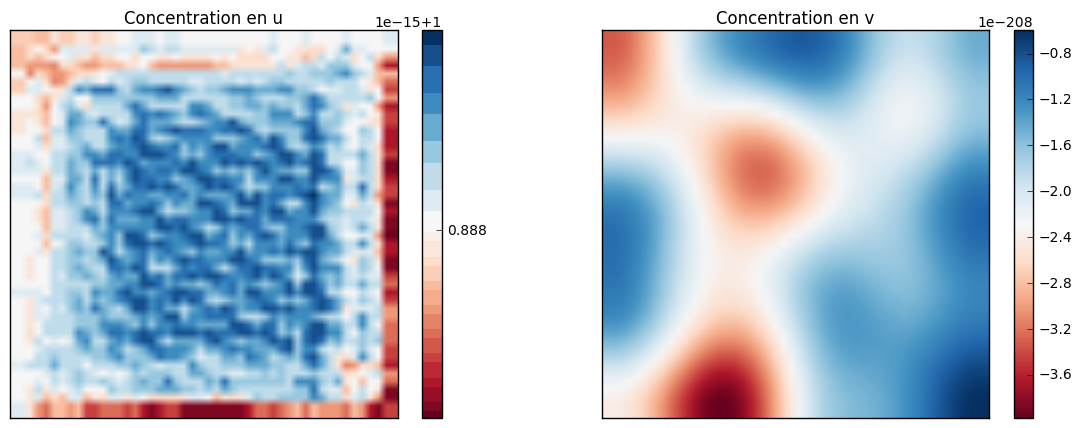

In [48]:
    fig = pyplot.figure(figsize=(14,5))
    pyplot.subplot(121)
    pyplot.imshow(sol[0], cmap = cm.RdBu)
    pyplot.title('Concentration en u')
    pyplot.xticks([]), pyplot.yticks([]);
    pyplot.colorbar()
    pyplot.subplot(122)
    pyplot.imshow(sol[1], cmap = cm.RdBu)
    pyplot.title('Concentration en v')
    pyplot.xticks([]), pyplot.yticks([]);
    pyplot.colorbar()